In [38]:
import os
import cv2
import shutil
import PIL
import random
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import model_selection
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# LOCAL VARIABLES
BASE_DIR = '../../dataset/'
SAVED_MODEL_DIR = BASE_DIR + '../model'

In [3]:
#DATASET_DIR = BASE_DIR + 'final_dataset/'
DATASET_DIR = BASE_DIR + 'dataset_nuovo/'
DATA_DIR = Path(DATASET_DIR)
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SIZE = 256

In [4]:
EPOCHS = 50
BATCH_SIZE = 128

In [5]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [57]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    seed = 123)
#ds_size = tf.data.experimental.cardinality(ds)
ds_size = 13586
print(f'[DEBUG] - ds_size: {ds_size}')
#train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds, ds_size)
class_names = ds.class_names
ds = ds.shuffle(10000, seed=12)
print(f'[INFO] - Class names: {class_names}')

Found 13586 files belonging to 3 classes.
[DEBUG] - ds_size: 13586
[INFO] - Class names: ['correctly-masked', 'not-masked', 'uncorrectly-masked']


In [58]:
x = []
y = []
for image, label in tqdm(ds.unbatch().take(-1)):
    img = image.numpy().astype("uint8")
    x.append(img)
    label = label.numpy()
    y.append(label)

x = np.array(x)
y = np.array(y)

13586it [00:34, 393.24it/s]


In [67]:
x_train, x_val_test, y_train, y_val_test = model_selection.train_test_split(x, y, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = model_selection.train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42)

In [82]:
num_classes = len(class_names)

model = Sequential([
  #data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(), 
  #layers.Conv2D(128, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  #layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

In [83]:
start_time = time.time()
epochs = EPOCHS
history = model.fit(
  x_train, y_train,
  validation_data = (x_val, y_val),
  epochs = epochs
)
model.save(SAVED_MODEL_DIR)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/5
255/255 [==============================] - 239s 938ms/step - loss: 0.1696 - accuracy: 0.9385 - val_loss: 0.0359 - val_accuracy: 0.9886
Epoch 2/5
255/255 [==============================] - 327s 1s/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0300 - val_accuracy: 0.9919
Epoch 3/5
255/255 [==============================] - 359s 1s/step - loss: 0.0171 - accuracy: 0.9950 - val_loss: 0.0279 - val_accuracy: 0.9915
Epoch 4/5
255/255 [==============================] - 348s 1s/step - loss: 0.0132 - accuracy: 0.9967 - val_loss: 0.0199 - val_accuracy: 0.9952
Epoch 5/5
255/255 [==============================] - 342s 1s/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.0328 - val_accuracy: 0.9915
INFO:tensorflow:Assets written to: ../../dataset/../model/assets
--- 1619.092836856842 seconds ---


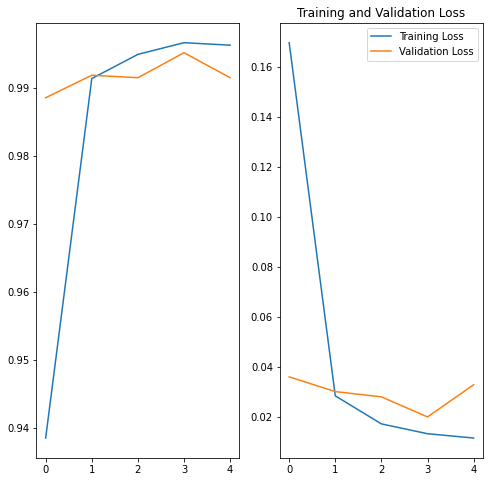

In [84]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [85]:
predictions = np.argmax(model.predict(x_test), axis=-1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, 
                            target_names = ['correctly-masked (Class 0)','not-masked (Class 1)', 'uncorrectly-masked (Class 2)']))

                              precision    recall  f1-score   support

  correctly-masked (Class 0)       1.00      0.99      0.99      1161
        not-masked (Class 1)       1.00      0.99      1.00       392
uncorrectly-masked (Class 2)       0.99      1.00      0.99      1165

                    accuracy                           0.99      2718
                   macro avg       1.00      0.99      0.99      2718
                weighted avg       0.99      0.99      0.99      2718



24576/17553 [==========================================] - 0s 0us/step
This image most likely belongs to not-masked with a 99.94 percent confidence.


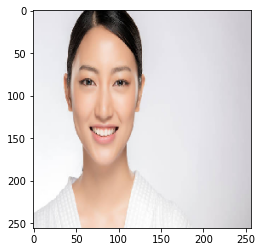

In [88]:
img_url =  "https://media.istockphoto.com/photos/beautiful-smiling-woman-with-clean-skin-picture-id1089292068?k=6&m=1089292068&s=612x612&w=0&h=esl0LAMEp_uastdwPu-SRjMOKi7vI33vP8L1O0ua3dU="
img_path = tf.keras.utils.get_file(f'{random.randint(0, 100000)}', origin=img_url)

img = keras.preprocessing.image.load_img(
    img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
_ = plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)